# App-ifying 'recovering data from images'

**See [the other notebook](Guessing_colourmaps.ipynb) for the grisly details and dead-ends.** 

Requirements:

- `numpy`
- `scipy`
- `scikit-learn`
- `pillow`

I recommend installing them with `conda install`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/matt/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics


## Make an image

Make some fake data and apply a colourmap.

In [2]:
from scipy import signal

In [3]:
nx, ny = 100, 100
z = np.random.rand(nx, ny)

sizex, sizey = 30, 30
x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
f = g/g.sum()

z = signal.convolve(z, f, mode='valid')
z = (z - z.min())/(z.max() - z.min())

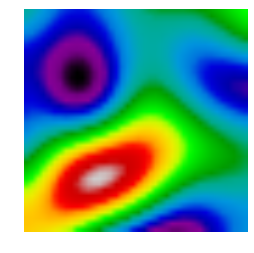

In [4]:
# Note: interpolation introduces new colours.
plt.imshow(z, cmap="spectral")
#plt.imshow(z, cmap="spectral", interpolation='none')

plt.axis('off')
plt.savefig('data/cbar/test.png', bbox_inches='tight')
plt.show()

## Read an image

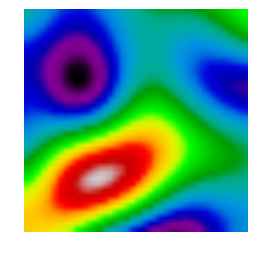

In [5]:
from PIL import Image

#im = Image.open('data/cbar/drainage.jpg')
img = Image.open('data/cbar/test.png')
img

In [6]:
img.size

(254, 253)

Instead of taking a random sample, let's take all pixels from a smaller version of the image.

In [7]:
def resize_if_necessary(img, max_size=256):
    h, w = img.size
    if h * w > max_size**2:
        img = img.resize((max_size, max_size))
    return img

In [8]:
img_sm = resize_if_necessary(img, 100)

Cast as an array, and ignore the last channel (alpha), if there is one.

Now we can plot all the pixels in the image into (R, G, B) space. As an added bonus, we can also colour the points with that (R, G, B) colour. 

In [9]:
i = np.asarray(img_sm)[:,:,:3]
# Re-organize the pixels to use rgb triples for colour
h, w, d = i.shape
c = i.reshape((h*w, d)) / 255.

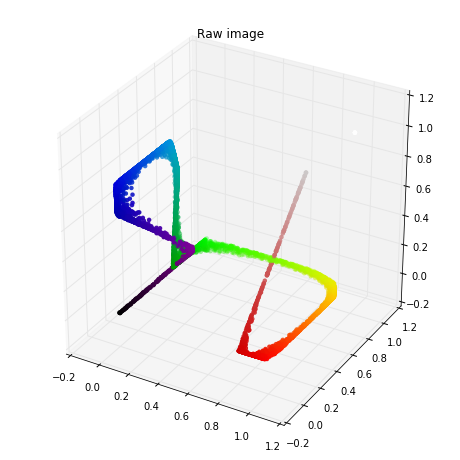

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the pixels!
ax.scatter(*c.T, c=c, lw=0)
ax.set_title('Raw image')

plt.show()

## Quantize with scikit

In [11]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [12]:
im = np.asarray(img) / 255.
h, w, d = im.shape
im_ = im.reshape((w * h, d))[:, :3]
sample = shuffle(im_, random_state=0)[:1000]  # Defines training set size

In [13]:
im.dtype, im.shape, im_.shape

(dtype('float64'), (253, 254, 4), (64262, 3))

In [14]:
kmeans = KMeans(n_clusters=256, random_state=0).fit(sample)

Now I can make and regularize an RGB palette `p`:

In [15]:
p = kmeans.cluster_centers_[:, :3]

# Make certain we're in [0, 1]
p[p<1e-9] = 0
p[p>1] = 1

In [16]:
labels = kmeans.predict(im_)

In [17]:
def recreate_image(palette, labels, h, w):
    image = np.zeros((h, w, palette.shape[1]))
    label_idx = 0
    for i in range(h):
        for j in range(w):
            image[i][j] = palette[labels[label_idx]]
            label_idx += 1
    return image

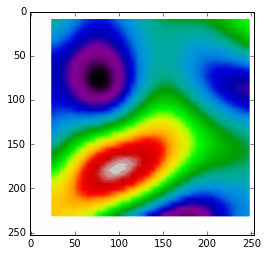

In [18]:
q = recreate_image(p, labels, h, w)

plt.imshow(q)
plt.show()

## Reconstructing the colourmap locus

Remember that these points are essentially in random order, and that there are many, many duplicates. Most of those dots are actually hundreds of dots.

We would like to measure ditances between dots. This is just a norm, but there's a convenient function in `scipy.spatial` for finding distances in *n*-space.

In [19]:
from scipy.spatial.distance import pdist, squareform, cdist
dists = squareform(pdist(p))

In [20]:
dists.shape, dists.size

((256, 256), 65536)

Each row is the set of distances for a point. Below is an excerpt of only the first 100 points.

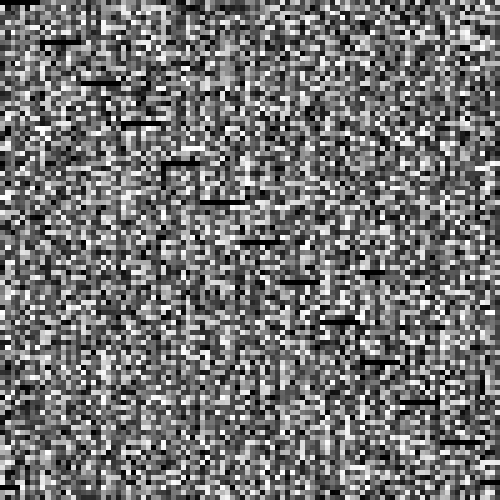

In [21]:
# The image is 10k x 10k pixels, so let's just look at a bit of it...
dist_img = Image.fromarray(dists[:100, :100]*255, 'P').resize((500, 500))
dist_img

I need an algorithm. I think this might work:

#### Preprocessing

* Find the median minimum non-zero distance between points, _m_ (nonzero because many points are exactly the same — colourbars are often only 6 or 8 bit).
* We are interested in points that are close to each other, but outside some minimum distance. Below the minimum distance, it's basically the same point. So ignore everything closer than some small distance _n_. Let's set _n_ to 0.2 &times; _m_ (we may need to change this).
* We want to eliminate points that are further than some maximum separation distance from the other points. Let's set _x_ to 5 &times; _m_.

#### Main loop

* Find the point nearest the origin. I think the blackest point is generally going to be the closest to 'zero' on the colorbar.
* Find the nearest point that is at least _n_ away.
* If the point is more than _x_ away, eliminate everything done so far and continue.
* If the point is less than _x_ away, keep the current points and continue.

After this, we'll have a minimal set of points, in order from blackest to the other end of the locus, wherever that is (not necessarily far from where we started.

In [22]:
# Start by eliminating duplicate rows — only needed for PIL quantization
def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

u = unique_rows(p)

In [23]:
len(u)

256

But we can't use this right now because we need to be able to look up the (r, g, b) triples for the pixels we identify. So we need their original coordinates.

Compute the median non-zero distance... 

In [24]:
#dists = squareform(pdist(p))

# This is the only way I could think of to eliminate the zeros and keep the shape.
dists[dists==0] = np.nan
mins = np.nanmin(dists, axis=0)

# Now get the median of these minimum nonzero distances.
m = np.median(mins)

# Now compute those numbers I was talking about.
n = m / 2
x = m * 5

In [25]:
m, n, x

(0.022183742154872097, 0.011091871077436049, 0.11091871077436048)

Let's compute the distance of every point from the black point, `[0, 0, 0]`.

In [26]:
target = cdist([[0,0,0]], u)
dists = squareform(pdist(u))

In [27]:
hits = [np.argmin(target)]  # Start with the first point.
i = 0

# Discretionary multipler. Higher numbers results in fewer points.
# Essentially, this is like selecting fewer colours to start with.
# 
z = 3

while i < len(u):
    i += 1
    
    # Eliminate everything close to target.
    dists[:, np.squeeze(np.where(target < z*n))] = 10
    target[target < z*n] = 10  # Eliminate everything close to target.

    # Get the next point in the locus.
    nearest = np.argmin(target)
    if nearest not in hits: hits.append(nearest)

    target = dists[nearest, :]

In [28]:
len(hits)

141

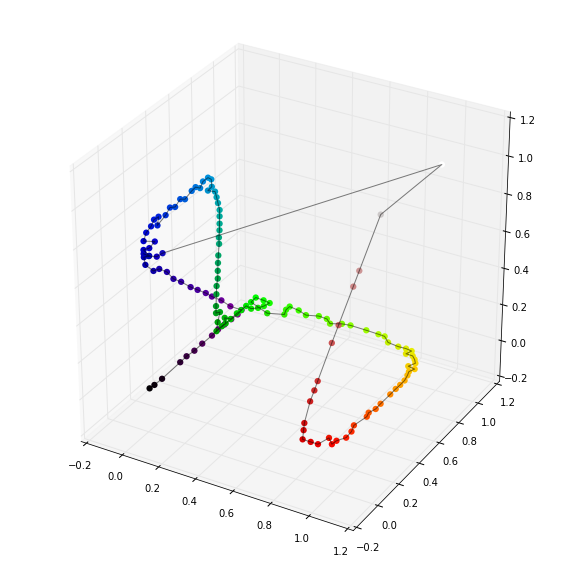

In [29]:
# Set up the figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the pixels!
ax.scatter(*u[hits].T, c=u[hits], lw=0, s=40, alpha=1)
ax.plot(*u[hits].T, color='k', alpha=0.5)
plt.show()

The alogithm is missing something: it's possible to find the closest points, making a locus, but leaving out a nearby point...

In [30]:
u[hits]

array([[  1.17647059e-02,   0.00000000e+00,   1.56862745e-02],
       [  3.92156863e-02,   0.00000000e+00,   4.31372549e-02],
       [  8.23529412e-02,   0.00000000e+00,   9.01960784e-02],
       [  1.84313725e-01,   0.00000000e+00,   2.11764706e-01],
       [  2.19607843e-01,   0.00000000e+00,   2.54901961e-01],
       [  2.62745098e-01,   0.00000000e+00,   2.98039216e-01],
       [  3.05882353e-01,   0.00000000e+00,   3.49019608e-01],
       [  3.58823529e-01,   0.00000000e+00,   4.07843137e-01],
       [  3.92156863e-01,   0.00000000e+00,   4.50980392e-01],
       [  4.25490196e-01,   0.00000000e+00,   4.86274510e-01],
       [  4.62745098e-01,   0.00000000e+00,   5.25490196e-01],
       [  4.96732026e-01,   0.00000000e+00,   5.60784314e-01],
       [  5.17647059e-01,   0.00000000e+00,   5.90196078e-01],
       [  4.58823529e-01,   0.00000000e+00,   5.92156863e-01],
       [  4.11764706e-01,   0.00000000e+00,   6.09150327e-01],
       [  3.61764706e-01,   0.00000000e+00,   6.1470588

Awesome!

<hr />

## Get all pixels using nearest neighbour

`cKDTree`, hopefully fast...

In [31]:
from scipy.spatial import cKDTree

In [32]:
kdtree = cKDTree(u[hits])

We get distances and indices simultaneously:

In [33]:
#im = im.reshape(h*w, d)
dx, ix = kdtree.query(im_)

In [34]:
dx.shape, ix.shape

((64262,), (64262,))

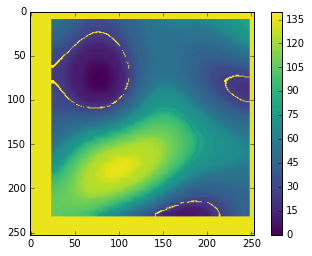

In [35]:
plt.imshow(ix.reshape((h, w)), cmap='viridis')
plt.colorbar()
plt.show()

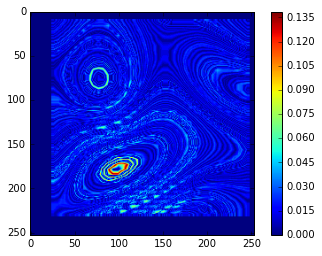

In [36]:
plt.imshow(dx.reshape((h, w)))
plt.colorbar()
plt.show()

We can apply a cutoff where the distance was unacceptably far.

In [37]:
ix = ix.astype(float)
ix[np.where(dx>0.2)] = np.nan

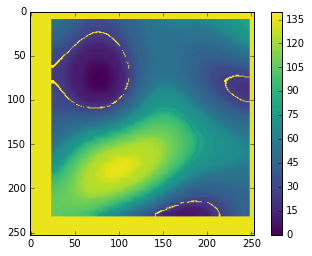

In [38]:
plt.imshow(ix.reshape((h, w)), cmap='viridis')
plt.colorbar()
plt.show()

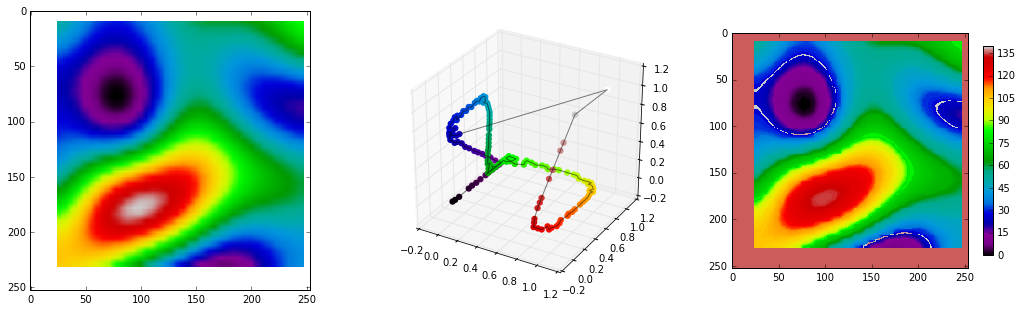

In [39]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(131)
plt.imshow(im, interpolation='none')

ax1 = fig.add_subplot(132, projection='3d')
ax1.scatter(*u[hits].T, c=u[hits], lw=0, s=40, alpha=1)
ax1.plot(*u[hits].T, color='k', alpha=0.5)

ax2 = fig.add_subplot(133)
plt.imshow(ix.reshape((h, w)), cmap="spectral", interpolation='none')
plt.colorbar(shrink=0.75)

plt.show()